In [1]:
import torch
from diffusers import UNet2DModel, AutoencoderKL

device = "cuda"
model = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)

/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/diffusers/utils/outputs.py:64: UserWarning: torch.utils._pytree._register_pytree_node is depr

In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from datasets import load_dataset

resolution = 256

augmentations = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

# augmentations = transforms.Compose(
#     [
#         transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR),
#         transforms.RandomCrop(resolution),
#         transforms.Lambda(lambda x: x),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5]),
#     ]
# )

def transform_images(examples):
    images = [augmentations(image.convert("RGB")) for image in examples["image"]]
    return {"input": images, "labels": examples["label"]}

train_batch_size = 4
train_dataset_path = "transient-attr-images/train"
train_ds = load_dataset("imagefolder", data_dir=train_dataset_path, split="train")
print(f"Train Dataset size: {len(train_ds)}")
train_ds.set_transform(transform_images)
train_dataloader = torch.utils.data.DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=0
)

Resolving data files:   0%|          | 0/2079 [00:00<?, ?it/s]

Train Dataset size: 2079


In [37]:
_x = next(iter(train_dataloader))
_x["labels"]

tensor([4, 3, 3, 1])

In [38]:
from diffusers.utils import pt_to_pil

imgs = pt_to_pil(_x["input"])
imgs

[<PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>,
 <PIL.Image.Image image mode=RGB size=256x256>]

In [32]:
# 1--> night
# 3 --> snow
# 4 --> sunny

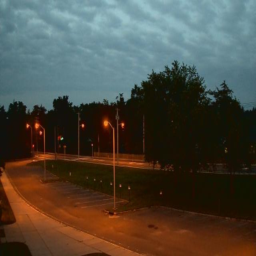

In [42]:
imgs[3]

In [3]:
from diffusers.utils import pt_to_pil, make_image_grid
model.eval()
with torch.no_grad():
    eval_batch = next(iter(eval_dataloader))
    eval_x = eval_batch["input"].to(device)
    reconstructions = model(eval_x).sample
    posterior = model.encode(eval_x).latent_dist
    z = posterior.mode()
    print(z.shape)
    sample_size = min(8, eval_x.shape[0])
    img_tensor = torch.cat([eval_x.cpu(), reconstructions.cpu()], axis=0)
    images = pt_to_pil(eval_x.cpu()) + pt_to_pil( reconstructions.cpu())
    
    img = make_image_grid(images, rows=2, cols=4)

torch.Size([4, 4, 32, 32])


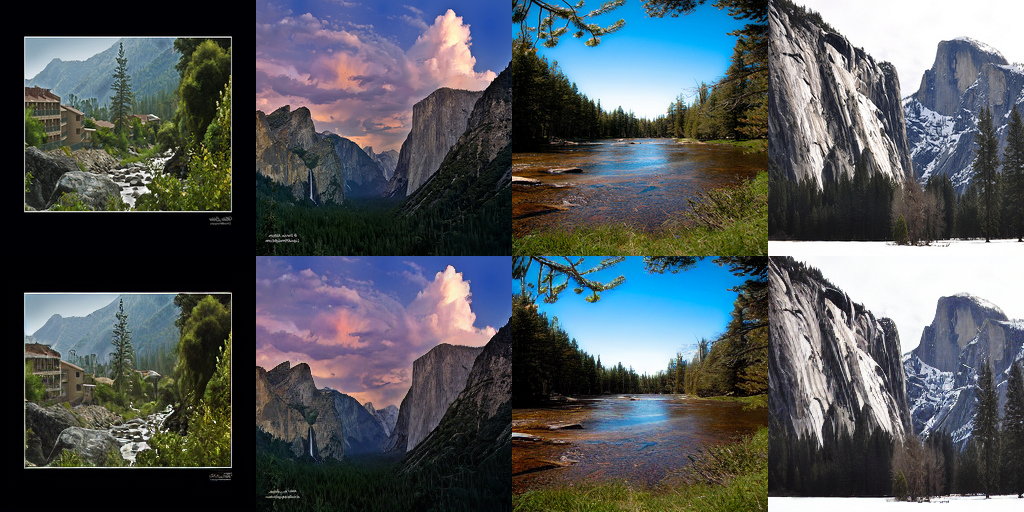

In [10]:
img

In [1]:
import torch
from vqvae import VQVAE, vqvae_config


# num_epochs = 20

# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# embedding_dim = 64
# num_embeddings = 512

# commitment_cost = 0.25

# decay = 0.99

# learning_rate = 5e-4
device = "cuda"
vae_model = VQVAE(vqvae_config["num_hiddens"], vqvae_config["num_residual_layers"], vqvae_config["num_residual_hiddens"],
              vqvae_config["num_embeddings"], vqvae_config["embedding_dim"], 
              vqvae_config["commitment_cost"], vqvae_config["decay"]).to(device)

In [2]:
vae_model.load_state_dict(torch.load("vqvae-yosemite-latest.pth"))

<All keys matched successfully>

In [2]:
import torch
from diffusers import UNet2DModel, AutoencoderKL
device = "cuda"
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).eval().to(device)


/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/diffusers/utils/outputs.py:64: UserWarning: torch.utils._pytree._register_pytree_node is depr

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset


dataset = load_dataset("imagefolder", data_dir="ddpm-data/summer2winter_yosemite/train", split="train")

from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    labels = [l for l in examples["label"]]
    return {"images": images, "labels": labels}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=True)


Resolving data files:   0%|          | 0/2193 [00:00<?, ?it/s]

/nfshomes/skarki/scratch/miniconda3/envs/llm/lib/python3.9/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [10]:
vae_model.eval()

_x = next(iter(train_dataloader))
valid_originals = _x["images"].to(device)

encoder_out = vae_model._encoder(valid_originals)
vq_output_eval = vae_model._pre_vq_conv(encoder_out)
_, valid_quantize, _, _ = vae_model._vq_vae(vq_output_eval)
valid_reconstructions = vae_model._decoder(valid_quantize)
print(valid_quantize.shape)

torch.Size([3, 64, 64, 64])


In [11]:
print(encoder_out.shape)

torch.Size([3, 128, 64, 64])


In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def show(img):
    print(type(img))
    npimg = img.numpy()
    plt.figure(figsize = (30,20))
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest',)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


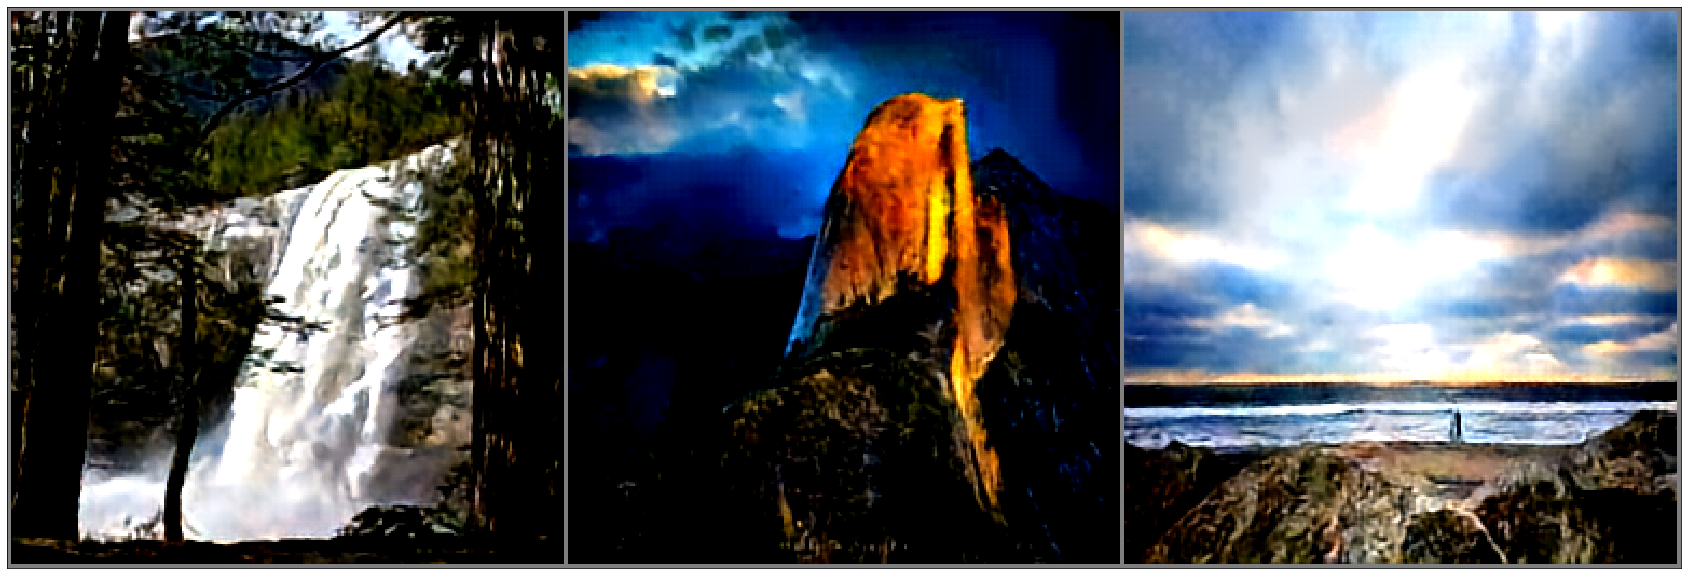

In [6]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


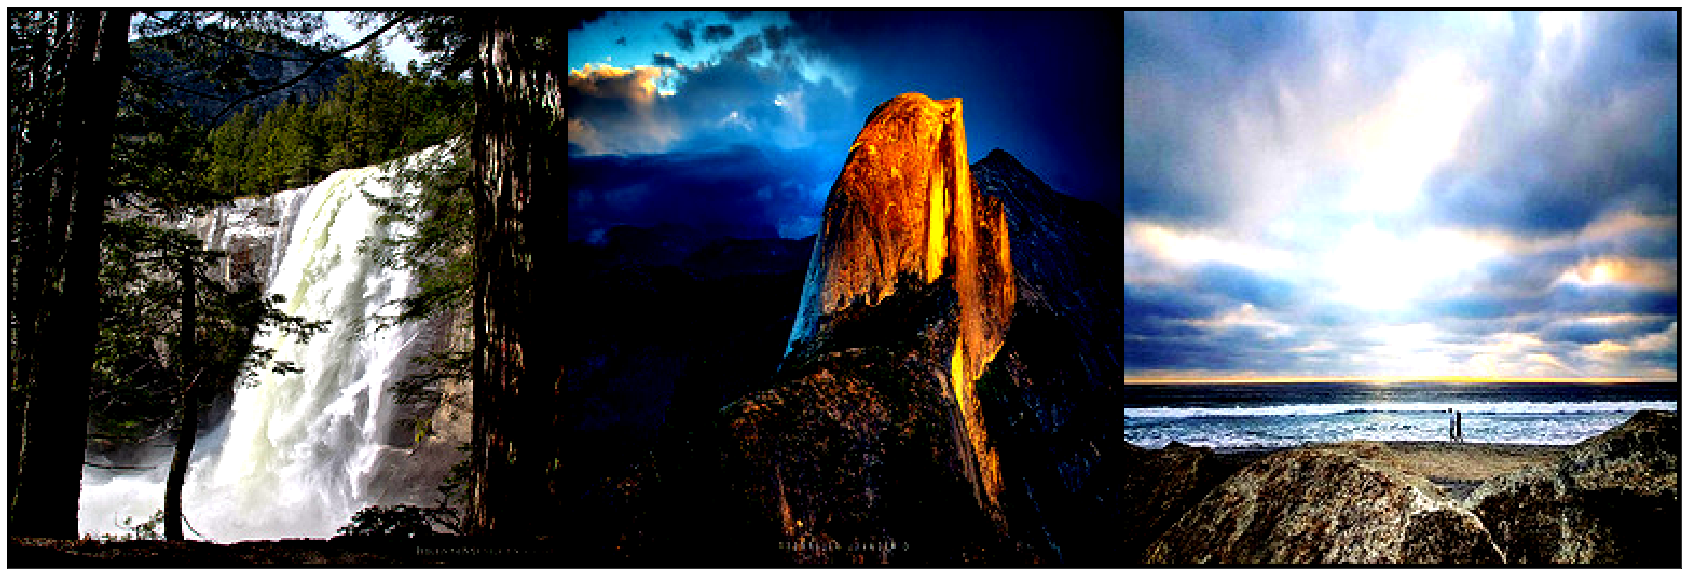

In [7]:
show(make_grid(valid_originals.cpu()+0.5))

In [6]:
batch = next(iter(train_dataloader))
batch["images"].shape

torch.Size([3, 3, 256, 256])

In [7]:
clean_images = batch['images'].to(device)
latents  = vae.encode(clean_images.to(dtype=torch.float16, device=device)).latent_dist.sample()
latents.shape

torch.Size([3, 4, 16, 16])

In [11]:
from PIL import Image 
def latents_to_pil(latents):     
    '''     
    Function to convert latents to images     
    '''     
    latents = (1 / 0.18215) * latents     
    with torch.no_grad():         
        image = vae.decode(latents).sample     
    
    image = (image / 2 + 0.5).clamp(0, 1)     
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()      
    images = (image * 255).round().astype("uint8")     
    pil_images = [Image.fromarray(image) for image in images]        
    return pil_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


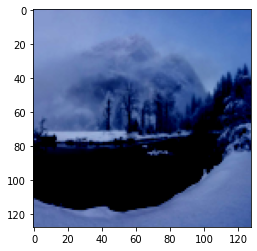

In [22]:
import matplotlib.pyplot as plt
plt.imshow(clean_images[0].cpu().permute(1, 2, 0).numpy())

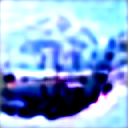

In [23]:
latents_to_pil(latents)[0]

In [9]:
# bs = clean_images.shape[0]
# class_labels = batch['labels'].to(device)
# timesteps = torch.randint(0, 1000, (bs,), device=clean_images.device).long()
# # noise_pred = unet(latents.float(), timesteps, class_labels=class_labels, return_dict=False)

In [106]:
unet.config.center_input_sample

False

In [10]:
from pprint import pprint
# 1. time
sample = clean_images
if not torch.is_tensor(timesteps):
    timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
    timesteps = timesteps[None].to(sample.device)

# broadcast to batch dimension in a way that's compatible with ONNX/Core ML
timesteps = timesteps * torch.ones(sample.shape[0], dtype=timesteps.dtype, device=timesteps.device)

t_emb = unet.time_proj(timesteps)

# timesteps does not contain any weights and will always return f32 tensors
# but time_embedding might actually be running in fp16. so we need to cast here.
# there might be better ways to encapsulate this.
t_emb = t_emb.to(dtype=unet.dtype)
emb = unet.time_embedding(t_emb)

if unet.class_embedding is not None:
    if class_labels is None:
        raise ValueError("class_labels should be provided when doing class conditioning")

    if unet.config.class_embed_type == "timestep":
        class_labels = self.time_proj(class_labels)

    class_emb = unet.class_embedding(class_labels).to(dtype=unet.dtype)
    emb = emb + class_emb
elif unet.class_embedding is None and class_labels is not None:
    raise ValueError("class_embedding needs to be initialized in order to use class conditioning")

emb.shape
# 2. pre-process
skip_sample = sample
sample = unet.conv_in(sample)

# 3. down
down_block_res_samples = (sample,)
for downsample_block in unet.down_blocks:
    if hasattr(downsample_block, "skip_conv"):
        sample, res_samples, skip_sample = downsample_block(
            hidden_states=sample, temb=emb, skip_sample=skip_sample
        )
    else:
        sample, res_samples = downsample_block(hidden_states=sample, temb=emb)

    down_block_res_samples += res_samples

pprint([d.shape for d in down_block_res_samples])
# 4. mid
sample = unet.mid_block(sample, emb)

# 5. up
skip_sample = None
for upsample_block in unet.up_blocks:
    res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
    down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

    if hasattr(upsample_block, "skip_conv"):
        sample, skip_sample = upsample_block(sample, res_samples, emb, skip_sample)
    else:
        sample = upsample_block(sample, res_samples, emb)

# # 6. post-process
# sample = self.conv_norm_out(sample)
# sample = self.conv_act(sample)
# sample = self.conv_out(sample)

# if skip_sample is not None:
#     sample += skip_sample

# if self.config.time_embedding_type == "fourier":
#     timesteps = timesteps.reshape((sample.shape[0], *([1] * len(sample.shape[1:]))))
#     sample = sample / timesteps

# if not return_dict:
#     return (sample,)


[torch.Size([3, 128, 128, 128]),
 torch.Size([3, 128, 128, 128]),
 torch.Size([3, 128, 128, 128]),
 torch.Size([3, 128, 64, 64]),
 torch.Size([3, 128, 64, 64]),
 torch.Size([3, 128, 64, 64]),
 torch.Size([3, 128, 32, 32]),
 torch.Size([3, 256, 32, 32]),
 torch.Size([3, 256, 32, 32]),
 torch.Size([3, 256, 16, 16]),
 torch.Size([3, 256, 16, 16]),
 torch.Size([3, 256, 16, 16]),
 torch.Size([3, 256, 8, 8]),
 torch.Size([3, 512, 8, 8]),
 torch.Size([3, 512, 8, 8]),
 torch.Size([3, 512, 4, 4]),
 torch.Size([3, 512, 4, 4]),
 torch.Size([3, 512, 4, 4])]


In [71]:
upsample_block.resnets

ModuleList(
  (0-1): 2 x ResnetBlock2D(
    (norm1): GroupNorm(32, 1024, eps=1e-05, affine=True)
    (conv1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_emb_proj): Linear(in_features=512, out_features=512, bias=True)
    (norm2): GroupNorm(32, 512, eps=1e-05, affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (nonlinearity): SiLU()
    (conv_shortcut): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1))
  )
  (2): ResnetBlock2D(
    (norm1): GroupNorm(32, 768, eps=1e-05, affine=True)
    (conv1): Conv2d(768, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_emb_proj): Linear(in_features=512, out_features=512, bias=True)
    (norm2): GroupNorm(32, 512, eps=1e-05, affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (nonlinearity): SiLU()
    (conv_shortcut

In [72]:
sample.shape, emb.shape, [r.shape for r in res_samples]

(torch.Size([3, 512, 4, 4]),
 torch.Size([3, 512]),
 [torch.Size([3, 256, 3, 3]),
  torch.Size([3, 512, 3, 3]),
  torch.Size([3, 512, 3, 3])])

In [11]:
[torch.Size([3, 128, 48, 48]),
 torch.Size([3, 128, 48, 48]),
 torch.Size([3, 128, 48, 48]),
 torch.Size([3, 128, 24, 24]),
 torch.Size([3, 128, 24, 24]),
 torch.Size([3, 128, 24, 24]),
 torch.Size([3, 128, 12, 12]),
 torch.Size([3, 256, 12, 12]),
 torch.Size([3, 256, 12, 12]),
 torch.Size([3, 256, 6, 6]),
 torch.Size([3, 256, 6, 6]),
 torch.Size([3, 256, 6, 6]),
 torch.Size([3, 256, 3, 3]),
 torch.Size([3, 512, 3, 3]),
 torch.Size([3, 512, 3, 3]),
 torch.Size([3, 512, 2, 2]),
 torch.Size([3, 512, 2, 2]),
 torch.Size([3, 512, 2, 2])]

<ipython-input-11-08a3ac9c11a9>:1: FutureWarning: Accessing config attribute `up_block_types` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'up_block_types' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.up_block_types'.
  unet.up_block_types


['UpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D']

In [61]:
unetc.config.cross_attention_dim

768

In [55]:
unetc = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
unetc.config

FrozenDict([('sample_size', 64),
            ('in_channels', 4),
            ('out_channels', 4),
            ('center_input_sample', False),
            ('flip_sin_to_cos', True),
            ('freq_shift', 0),
            ('down_block_types',
             ['CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'CrossAttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2DCrossAttn'),
            ('up_block_types',
             ['UpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D',
              'CrossAttnUpBlock2D']),
            ('only_cross_attention', False),
            ('block_out_channels', [320, 640, 1280, 1280]),
            ('layers_per_block', 2),
            ('downsample_padding', 1),
            ('mid_block_scale_factor', 1),
            ('dropout', 0.0),
            ('act_fn', 'silu'),
            ('norm_num_groups', 32),
            ('norm_eps', 1e-05),
            ('cross_attenti

In [1]:
from datasets import load_from_disk

ds = load_from_disk("data/transient-attributes-dataset")
ds

DatasetDict({
    train: Dataset({
        features: ['path', 'label'],
        num_rows: 2201
    })
    test: Dataset({
        features: ['path', 'label'],
        num_rows: 551
    })
})

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Conv3(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU(),
        )

        self.is_res = is_res

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.main(x)
        if self.is_res:
            x = x + self.conv(x)
            return x / 1.414
        else:
            return self.conv(x)


class UnetDown(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(UnetDown, self).__init__()
        layers = [Conv3(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            Conv3(out_channels, out_channels),
            Conv3(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = torch.cat((x, skip), 1)
        x = self.model(x)

        return x


class TimeSiren(nn.Module):
    def __init__(self, emb_dim: int) -> None:
        super(TimeSiren, self).__init__()

        self.lin1 = nn.Linear(1, emb_dim, bias=False)
        self.lin2 = nn.Linear(emb_dim, emb_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 1)
        x = torch.sin(self.lin1(x))
        x = self.lin2(x)
        return x


class NaiveUnet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, n_feat: int = 256) -> None:
        super(NaiveUnet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.n_feat = n_feat

        self.init_conv = Conv3(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(4), nn.ReLU())

        self.timeembed = TimeSiren(2 * n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 4, 4),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Conv2d(2 * n_feat, self.out_channels, 3, 1, 1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:

        x = self.init_conv(x)

        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)

        thro = self.to_vec(down3)
        temb = self.timeembed(t).view(-1, self.n_feat * 2, 1, 1)

        thro = self.up0(thro + temb)

        up1 = self.up1(thro, down3) + temb
        up2 = self.up2(up1, down2)
        up3 = self.up3(up2, down1)

        out = self.out(torch.cat((up3, x), 1))

        return out

In [3]:
from typing import Dict, Tuple


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


class DDPM(nn.Module):
    def __init__(
        self,
        eps_model: nn.Module,
        betas: Tuple[float, float],
        n_T: int,
        criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super(DDPM, self).__init__()
        self.eps_model = eps_model

        # register_buffer allows us to freely access these tensors by name. It helps device placement.
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Makes forward diffusion x_t, and tries to guess epsilon value from x_t using eps_model.
        This implements Algorithm 1 in the paper.
        """

        _ts = torch.randint(1, self.n_T + 1, (x.shape[0],)).to(x.device)
        # t ~ Uniform(0, n_T)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * eps
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        return self.criterion(eps, self.eps_model(x_t, _ts / self.n_T))

    def sample(self, n_sample: int, size, device) -> torch.Tensor:

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)

        # This samples accordingly to Algorithm 2. It is exactly the same logic.
        for i in range(self.n_T, 0, -1):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.eps_model(
                x_i, torch.tensor(i / self.n_T).to(device).repeat(n_sample, 1)
            )
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )

        return x_i


def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

In [4]:
from typing import Dict, Tuple

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



# https://arxiv.org/abs/2010.02502
class DDIM(DDPM):
    def __init__(
            self,
            eps_model: nn.Module,
            betas: Tuple[float, float],
            eta: float,
            n_T: int,
            criterion: nn.Module = nn.MSELoss(),
    ) -> None:
        super(DDIM, self).__init__(eps_model, betas, n_T, criterion)
        self.eta = eta

    # modified from https://github.com/ermongroup/ddim/blob/51cb290f83049e5381b09a4cc0389f16a4a02cc9/functions/denoising.py#L10-L32
    def sample(self, n_sample: int, size, device) -> torch.Tensor:
        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)

        for i in range(self.n_T, 1, -1):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.eps_model(x_i, torch.tensor(i / self.n_T).to(device).repeat(n_sample, 1))
            x0_t = (x_i - eps * (1 - self.alphabar_t[i]).sqrt()) / self.alphabar_t[i].sqrt()
            c1 = self.eta * ((1 - self.alphabar_t[i] / self.alphabar_t[i - 1]) * (1 - self.alphabar_t[i - 1]) / (
                    1 - self.alphabar_t[i])).sqrt()
            c2 = ((1 - self.alphabar_t[i - 1]) - c1 ** 2).sqrt()
            x_i = self.alphabar_t[i - 1].sqrt() * x0_t + c1 * z + c2 * eps

        return x_i

In [10]:
from tqdm.auto import trange, tqdm
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import save_image, make_grid

DATASET_PATH = "transient-attr-images/train"
n_epoch = 100
device = "cuda"
load_pth = None

ddpm = DDPM(eps_model=NaiveUnet(3, 3, n_feat=128), betas=(1e-4, 0.02), n_T=1000)

if load_pth is not None:
    ddpm.load_state_dict(torch.load("ddpm_transient.pth"))

ddpm.to(device)

tf = transforms.Compose(  # resize to 512 x 512, convert to tensor, normalize
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

dataset = ImageFolder(
    root=DATASET_PATH,
    transform=tf,
)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
optim = torch.optim.Adam(ddpm.parameters(), lr=2e-5)

for i in trange(n_epoch):
    print(f"Epoch {i} : ")
    ddpm.train()

    pbar = tqdm(dataloader)
    loss_ema = None
    for x, _ in pbar:
        optim.zero_grad()
        x = x.to(device)
        loss = ddpm(x)
        loss.backward()
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.9 * loss_ema + 0.1 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()

    ddpm.eval()
    with torch.no_grad():
        xh = ddpm.sample(8, (3, 128, 128), device)
        xset = torch.cat([xh, x[:8]], dim=0)
        grid = make_grid(xset, normalize=True, value_range=(-1, 1), nrow=4)
        save_image(grid, f"./contents/ddpm_sample_celeba{i:03d}.png")

        # save model
        torch.save(ddpm.state_dict(), f"./ddpm_celeba.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 : 


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1 : 


  0%|          | 0/65 [00:00<?, ?it/s]

KeyboardInterrupt: 